### Aprendizado de Máquina Lição 5: Criando Rede Neural e modelo linear

## Autor
**Nome**: Pedro Lucas Cassiano Martins<br>
**Matrícula**: 190036567<br>
**Github**: [PedroLucasCM](github.com/PedroLucasCM)

## Objetivo
<p>O objetivo deste artigo 3 foi o de estudar modelos lineares e redes neurais com o fast.ai. Nesse artigo, o objetivo é o de criar um modelo linear e uma rede neural do zero com a ajuda das bibliotecas pytorch, numpy e pandas.</p>


## Atualização e Imports

In [1]:
import os
import warnings

# Código para ignorar avisos de usuário
warnings.filterwarnings("ignore", category=UserWarning)

#!pip install -Uqq torch==2.0.1
#!pip install -Uqq torchdata==0.6.1

from fastai.data.transforms import RandomSplitter
from pathlib import Path
import torch
from torch import tensor
import numpy as np
import pandas as pd
import sympy
import torch.nn.functional as F

In [2]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Dataset

Nesse artigo será usado o dataset da competição [Prediction of Wild Blueberry Yield](https://www.kaggle.com/competitions/playground-series-s3e14/overview) que foi utilizado para predizer a quantidade de mirtilos colhidos baseados em alguns fatores como densidade de vários tipos de abelha, dias de chuva e dias de sol, temperatura do ar, quantidade de sementes e tamanho dos 'clones' de mirtilo. 

## Execução
### Limpando os dados

Primeiramente vamos colocar o path do dataset da competição:

In [3]:
path = Path('/kaggle/input/playground-series-s3e14')

Podemos então criar e abrir o dataset de treino para visualizar as colunas e valores com que vamos trabalhar

In [4]:
df = pd.read_csv(path/'train.csv')
df

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,15284,12.5,0.25,0.25,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.556302,0.476308,40.546480,7667.83619
15285,15285,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.354413,0.388145,29.467434,3680.56025
15286,15286,25.0,0.50,0.25,0.38,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.422548,0.416786,32.299059,4696.44394
15287,15287,25.0,0.50,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.542170,0.434133,36.674243,6772.93347


Não podemos trabalhar com valores que não existem, então vamos checar se a tabela possui valores **NaN** (*not a number*):

In [5]:
df.isna().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

O número na direita é a quantidade de valores **NaN** para cada coluna, para removê-los podemos tirar a moda entre os valores daquela coluna e usar o resultado para preencher o campo **NaN**. E então veremos que não tem mais colunas vazias.

In [6]:
modes = df.mode().iloc[0]
modes

id                         0.000000
clonesize                 25.000000
honeybee                   0.500000
bumbles                    0.250000
andrena                    0.380000
osmia                      0.630000
MaxOfUpperTRange          86.000000
MinOfUpperTRange          52.000000
AverageOfUpperTRange      71.900000
MaxOfLowerTRange          62.000000
MinOfLowerTRange          30.000000
AverageOfLowerTRange      50.800000
RainingDays               16.000000
AverageRainingDays         0.260000
fruitset                   0.583379
fruitmass                  0.446570
seeds                     39.988734
yield                   6251.611840
Name: 0, dtype: float64

In [7]:
df.fillna(modes, inplace=True)
df.isna().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

Vamos checar as colunas com valores numéricos que são todas:

In [8]:
df.describe(include=(np.number))

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


Temos uma coluna `yield` que representa a quantidade de blueberries na colheita de cada `id`. Podemos ver o histograma dessa coluna a seguir: 

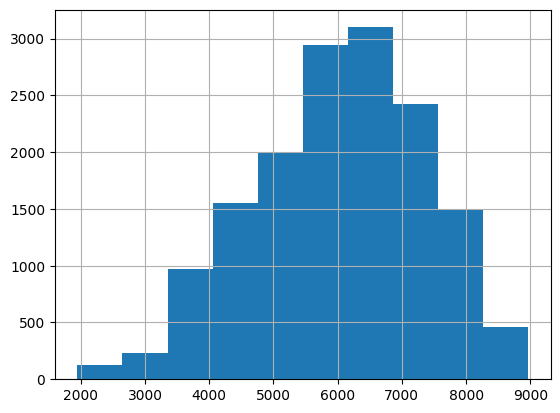

In [9]:
df['yield'].hist();

A grande maioria dos valores está entre 3000 e 9000. Usaremos então uma função logarítimica para diminuir essa quantidade e não ter problema na hora do cálculo com o coeficiente:

In [10]:
df['LogYield'] = np.log(df['yield']+1)

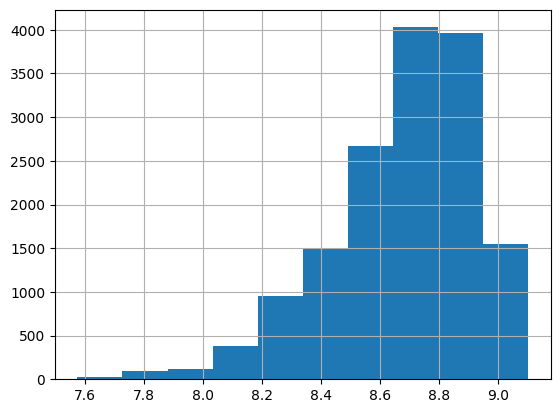

In [11]:
df['LogYield'].hist();

Podemos ver que diminuiu bastante para 7.6 e 9.

In [12]:
df.columns

Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass',
       'seeds', 'yield', 'LogYield'],
      dtype='object')

Podemos criar nossas variáveis independentes (usadas na predição) e dependentes (que será inferido). Elas devem ser tensores do PyTorch.

In [13]:
t_dep = tensor(df['LogYield'])
indep_columns = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass',
       'seeds']

t_indep = tensor(df[indep_columns].values, dtype=torch.float)
t_indep

tensor([[25.0000,  0.5000,  0.2500,  0.7500,  0.5000, 69.7000, 42.1000,  ..., 24.3000, 41.2000, 24.0000,  0.3900,  0.4250,  0.4175,
         32.4609],
        [25.0000,  0.5000,  0.2500,  0.5000,  0.5000, 69.7000, 42.1000,  ..., 24.3000, 41.2000, 24.0000,  0.3900,  0.4449,  0.4221,
         33.8583],
        [12.5000,  0.2500,  0.2500,  0.6300,  0.6300, 86.0000, 52.0000,  ..., 30.0000, 50.8000, 24.0000,  0.3900,  0.5529,  0.4709,
         38.3418],
        [12.5000,  0.2500,  0.2500,  0.6300,  0.5000, 77.4000, 46.8000,  ..., 27.0000, 45.8000, 24.0000,  0.3900,  0.5660,  0.4781,
         39.4676],
        [25.0000,  0.5000,  0.2500,  0.6300,  0.6300, 77.4000, 46.8000,  ..., 27.0000, 45.8000, 24.0000,  0.3900,  0.5797,  0.4942,
         40.4845],
        [25.0000,  0.5000,  0.2500,  0.6300,  0.7500, 94.6000, 57.2000,  ..., 33.0000, 55.9000, 34.0000,  0.5600,  0.5652,  0.4843,
         40.5550],
        [12.5000,  0.2500,  0.3800,  0.5000,  0.6300, 86.0000, 52.0000,  ..., 30.0000, 50.8000

In [14]:
t_indep.shape

torch.Size([15289, 16])

In [15]:
indep_columns

['clonesize',
 'honeybee',
 'bumbles',
 'andrena',
 'osmia',
 'MaxOfUpperTRange',
 'MinOfUpperTRange',
 'AverageOfUpperTRange',
 'MaxOfLowerTRange',
 'MinOfLowerTRange',
 'AverageOfLowerTRange',
 'RainingDays',
 'AverageRainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

In [16]:
df

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,LogYield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,8.406890
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,8.621395
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,8.835033
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590,8.836632
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417,8.920113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,15284,12.5,0.25,0.25,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.556302,0.476308,40.546480,7667.83619,8.944920
15285,15285,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.354413,0.388145,29.467434,3680.56025,8.211092
15286,15286,25.0,0.50,0.25,0.38,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.422548,0.416786,32.299059,4696.44394,8.454774
15287,15287,25.0,0.50,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.542170,0.434133,36.674243,6772.93347,8.820837


### Criando Modelo Linear

Com a matriz de variáveis independentes e o vetor de variável dependente podemos calcular as predições e a perda. Nessa seção vamos fazer manualmente um passo desse cálculo para cada linha.

O primeiro modelo será linear, e precisa de um coeficiente para cada coluna, então vamos pegar valores aleatórios entre `(-0.5, 0.5)`.

In [17]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5

In [18]:
t_indep*coeffs

tensor([[     5.3536,      0.2246,      0.0332,     -0.0503,     -0.2364,    -17.8891,    -19.6246,  ...,     -4.7420,      2.7107,
              3.3869,      0.1890,     -0.1373,      0.0435,    -14.6909],
        [     5.3536,      0.2246,      0.0332,     -0.0335,     -0.2364,    -17.8891,    -19.6246,  ...,     -4.7420,      2.7107,
              3.3869,      0.1890,     -0.1438,      0.0440,    -15.3233],
        [     2.6768,      0.1123,      0.0332,     -0.0422,     -0.2979,    -22.0726,    -24.2394,  ...,     -5.8544,      3.3423,
              3.3869,      0.1890,     -0.1787,      0.0490,    -17.3524],
        [     2.6768,      0.1123,      0.0332,     -0.0422,     -0.2364,    -19.8654,    -21.8155,  ...,     -5.2689,      3.0133,
              3.3869,      0.1890,     -0.1829,      0.0498,    -17.8619],
        [     5.3536,      0.2246,      0.0332,     -0.0422,     -0.2979,    -19.8654,    -21.8155,  ...,     -5.2689,      3.0133,
              3.3869,      0.1890,     -

Podemos ver que a coluna da Idade possui uma média muito maior do que as outras, o que pode afetar nosso modelo, então vamos restringir as colunas a valores de 0 a 1.

In [19]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
t_indep*coeffs

tensor([[ 0.1338,  0.0122,  0.0567, -0.0670, -0.3152, -0.1891, -0.3431,  ..., -0.1437,  0.0485,  0.0996,  0.3375, -0.2106,  0.0812,
         -0.3154],
        [ 0.1338,  0.0122,  0.0567, -0.0447, -0.3152, -0.1891, -0.3431,  ..., -0.1437,  0.0485,  0.0996,  0.3375, -0.2204,  0.0820,
         -0.3289],
        [ 0.0669,  0.0061,  0.0567, -0.0563, -0.3971, -0.2333, -0.4238,  ..., -0.1774,  0.0598,  0.0996,  0.3375, -0.2739,  0.0915,
         -0.3725],
        [ 0.0669,  0.0061,  0.0567, -0.0563, -0.3152, -0.2100, -0.3814,  ..., -0.1597,  0.0539,  0.0996,  0.3375, -0.2804,  0.0930,
         -0.3834],
        [ 0.1338,  0.0122,  0.0567, -0.0563, -0.3971, -0.2100, -0.3814,  ..., -0.1597,  0.0539,  0.0996,  0.3375, -0.2872,  0.0961,
         -0.3933],
        [ 0.1338,  0.0122,  0.0567, -0.0563, -0.4728, -0.2567, -0.4661,  ..., -0.1951,  0.0658,  0.1411,  0.4847, -0.2800,  0.0942,
         -0.3940],
        [ 0.0669,  0.0061,  0.0862, -0.0447, -0.3971, -0.2333, -0.4238,  ..., -0.1774,  0.0598

Podemos então somar as linhas do produto para criar inferências:

In [20]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([-1.3325, -1.3327, -1.8561, -1.6485, -1.6710, -1.8361, -1.7663, -2.3481, -2.0634, -1.5542])

Para utilizar o método do gradiente devemos ter uma função de perda, então vamos criar uma que representa o erro médio das linhas:

In [21]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(10.4203, dtype=torch.float64)

Podemos então colocar esses cálculos dentro de funções para usar mais adiante.

In [22]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### Método do gradiente

Vamos fazer uma única época do método do gradiente. Para calcular os gradientes, devemos usar `requires_grad_()` nos coeficientes.

In [23]:
coeffs.requires_grad_()
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(10.4203, dtype=torch.float64, grad_fn=<MeanBackward0>)

Para calcular os gradientes, usamos a função `backward()`:

In [24]:
loss.backward()
coeffs.grad

tensor([-0.4926, -0.0211, -0.4902, -0.6569, -0.7898, -0.8686, -0.8684, -0.8691, -0.8685, -0.8685, -0.8688, -0.5488, -0.5789, -0.7709,
        -0.8336, -0.7763])

A cada chamada do `backward()` os gradientes são somados ao que estiver no atributo `grad`:

In [25]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.9852, -0.0422, -0.9804, -1.3138, -1.5796, -1.7372, -1.7368, -1.7381, -1.7369, -1.7370, -1.7377, -1.0977, -1.1578, -1.5418,
        -1.6673, -1.5526])

Por isso devemos tornar os gradientes em 0 depois de cada passo.  
Vamos realizar um passo e checar se a perda diminui:

In [26]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(7.8420, dtype=torch.float64)


Obs: No PyTorch, métodos terminados em `_` realizam a operação *in-place*.

## Treinando o modelo

Primeiro vamos separar um conjunto de dados para treino e outro para validação:

In [27]:
trn_split, val_split = RandomSplitter(seed=42)(df)

A função `RandomSplitter` vai retornar índices para separação dos dados. Esses índices podem então ser aplicados nos nossos valores dependentes e independentes.

In [28]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(12232, 3057)

Vamos criar funções para realizar os passos acima:

In [29]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

E usá-las para treinar o modelo.

In [30]:
coeffs = train_model(18, lr=0.2)

8.493; 6.775; 5.056; 3.338; 1.620; 0.660; 0.647; 0.638; 0.627; 0.618; 0.608; 0.600; 0.592; 0.584; 0.577; 0.571; 0.565; 0.560; 

Podemos ver nosso erro diminuindo a cada época. A seguir vamos printar os coeficientes para cada coluna:

In [31]:
def show_coeffs(): return dict(zip(indep_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'clonesize': tensor(0.0490),
 'honeybee': tensor(0.1610),
 'bumbles': tensor(0.7808),
 'andrena': tensor(0.4807),
 'osmia': tensor(0.5919),
 'MaxOfUpperTRange': tensor(0.4982),
 'MinOfUpperTRange': tensor(1.2998),
 'AverageOfUpperTRange': tensor(1.1269),
 'MaxOfLowerTRange': tensor(1.0923),
 'MinOfLowerTRange': tensor(0.3733),
 'AverageOfLowerTRange': tensor(1.0239),
 'RainingDays': tensor(0.5964),
 'AverageRainingDays': tensor(0.4977),
 'fruitset': tensor(1.1524),
 'fruitmass': tensor(0.5955),
 'seeds': tensor(0.9063)}

#### Medindo acurácia

Como a métrica pedida na competição é a acurácia (proporção de inferências corretas), vamos ver quão bem nosso modelo se sai. Primeiramente devemos calcular as inferências:

In [32]:
preds = calc_preds(coeffs, val_indep)
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True])

Acima, consideramos os casos em que a inferência é maior que 0.5 como positiva, ou seja, o passageiro foi transportado.

Vamos fazer uma função que calcula as inferências e retorna a acurácia:

In [33]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(1.)

### Função sigmoide

Um problema presente nas nossas predições é que existem valores menores que 0 e maiores que 1.

In [34]:
preds[:28]

tensor([7.9583, 8.1989, 7.3454, 9.3179, 8.0163, 9.5029, 8.5383, 8.5354, 8.1531, 8.2245, 8.6480, 8.1722, 8.2894, 8.7049, 8.6546, 7.4590,
        9.1620, 8.2221, 9.6217, 7.9399, 8.4587, 7.8910, 7.8839, 9.3815, 8.3388, 8.7938, 8.9586, 8.3382])

Isso pode ser resolvido passando os valores por uma função sigmoide, que varia entre 0 e 1 de acordo com a entrada:

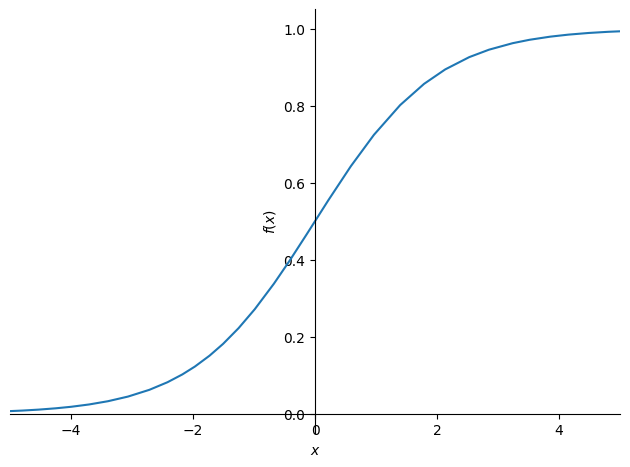

In [35]:
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

o `PyTorch` já possui essa função, então podemos modificar a `calc_preds` para incluí-la:

In [36]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

coeffs = train_model(lr=100)

8.130; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 

A perda diminuiu consideravelmente, agora vejamos a acurácia:

In [37]:
acc(coeffs)

tensor(1.)

O uso da função sigmoide acarretou em uma melhora de `0.74` para `0.76`.  
A seguir os coeficientes do nosso modelo:

In [38]:
show_coeffs()

{'clonesize': tensor(11.6583),
 'honeybee': tensor(0.6569),
 'bumbles': tensor(12.2769),
 'andrena': tensor(15.9287),
 'osmia': tensor(19.1410),
 'MaxOfUpperTRange': tensor(20.9968),
 'MinOfUpperTRange': tensor(21.7944),
 'AverageOfUpperTRange': tensor(21.6367),
 'MaxOfLowerTRange': tensor(21.5882),
 'MinOfLowerTRange': tensor(20.8700),
 'AverageOfLowerTRange': tensor(21.5280),
 'RainingDays': tensor(13.6970),
 'AverageRainingDays': tensor(14.2551),
 'fruitset': tensor(19.1743),
 'fruitmass': tensor(20.1153),
 'seeds': tensor(19.0659)}

### Conjunto de teste e submissão

Para gerar o arquivo de inferências e submeter ao kaggle, precisamos ver como o modelo se sai no conjunto de teste:

In [39]:
tst_df = pd.read_csv(path/'test.csv')

A seguir fazemos as mesmas adaptações da seção de limpeza dos dados:

In [40]:
tst_df.fillna(modes, inplace=True)
tst_df['LogYield'] = np.log(df['LogYield']+1)

tst_indep = tensor(tst_df[indep_columns].values, dtype=torch.float)
tst_indep = tst_indep / vals

E geramos a coluna *LogYield*, que é o nosso alvo, para guardar as inferências.

In [41]:
tst_df['LogYield'] = (calc_preds(tst_indep, coeffs)>0.5)

Guardamos as colunas relevantes em outro dataframe, e exportamos ele para um arquivo `.csv`:

In [42]:
sub_df = tst_df[['id','LogYield']]
sub_df.to_csv('sub.csv', index=False)

Aqui estão as primeiras linhas do arquivo:

In [43]:
!head sub.csv

id,LogYield
15289,True
15290,True
15291,True
15292,True
15293,True
15294,True
15295,True
15296,True
15297,True


#### Otimizações

Antes de prosseguir para a próxima parte, podemos fazer algumas otimizações.

O código `(indeps*coeffs).sum(axis=1)` nada mais é do que uma multiplicação de matrizes, e essa operação é suportada pelos tensores do PyTorch e representada pelo python através do operador `@`. A sua execução acaba sendo mais eficiente dessa forma, pois produto de matrizes é uma operação bem otimizada no PyTorch.

In [44]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

Acima atualizamos o `calc_preds` para utilizar a multiplicação de matrizes, e o `init_coeffs` para gerar nossos coeficientes em forma de um vetor coluna, ou seja, uma matriz com uma única coluna, para podermos realizar produtos entre matrizes na próxima seção.

Precisamos também transformar as variáveis dependentes em um vetor coluna. Isso pode ser feito indexando a coluna com o valor `None`, que diz ao PyTorch para adicionar uma dimensão nessa posição: 

In [45]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

### Rede neural

Podemos enfim implementar uma rede neural.

Primeiramente devem ser criados coeficientes para cada camada. Os primeiros coeficientes vão tomar nossa entrada `n_coeff`, e criar um número de entradas `n_hidden`. Esse número pode ser o que o usuário quiser, sendo que um número maior oferece mais flexibilidade, mas torna a rede mais lenta e difícil de treinar.

Então teremos uma matriz de dimensão `n_coeff` por `n_hidden`. Esses coeficientes serão então divididos por `n_hidden` para termos números com a magnitude similar aos nossos iniciais após realizarmos a soma na próxima camada.

A segunda camada pegará as entradas `n_hidden` e retornará uma única saída, então precisamos de uma matriz de dimensão `n_hidden` por 1. A segunda camada também precisa de um termo constante adicionado.

In [46]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Podemos agora criar a rede neural.

Os passos essenciais são os dois produtos de matrizes:
1. `indeps@l1`: variáveis independentes * camada 1
2. `res@l2`: resultado da operação acima * camada 2

A saída da primeira camada é passada por uma função retificada linear, e a da segunda é passada por uma sigmoide.

Por fim, criamos um loop para atualizar cada conjunto de coeficientes:

In [47]:
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Podemos agora treinar o modelo.

In [48]:
coeffs = train_model(lr=20)

8.144; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 7.675; 

Nota-se uma melhora na perda. Vejamos a acurácia:

In [49]:
acc(coeffs)

tensor(1.)

Em termos de acurácia a performance da rede neural em contraste com o modelo linear não melhorou. Isso é de se esperar, visto que nosso dataset é simples e nosso conjunto de validação é pequeno.

### 5. Conclusão

Não é um procedimento muito prático, mas é muito gratificante construir uma rede neural do nada, especialmente após ter feito algumas com a ajuda de uma biblioteca como o fastai.

O que mais me chamou atenção nessa aula foi a parte de limpeza dos dados, principalmente as maneiras criativas de se tornar valores inutilizáveis em algo que nosso modelo possa processar.